In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io # pip install scikit-image
import os
import glob
import random
# from google.colab import files

from sklearn.preprocessing import StandardScaler, normalize

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend as K

In [2]:
# get the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

In [3]:
mw = np.array(base_model.weights)
mw.shape

(318,)

In [4]:
mw[-1]

<tf.Variable 'conv5_block3_3_bn/moving_variance:0' shape=(2048,) dtype=float32, numpy=
array([0.0099396 , 0.00943395, 0.01045332, ..., 0.00850692, 0.01214169,
       0.00997391], dtype=float32)>

In [5]:
df_brain = pd.read_csv('data_mask.csv')

In [6]:
df_brain.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [7]:
df_brain['mask'].dtype

dtype('int64')

In [8]:
# split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_valid = train_test_split(df_brain, test_size=0.2, random_state=12345)
X_valid, X_test = train_test_split(X_valid, test_size=0.5, random_state=12345)

In [9]:
X_train['mask']

854     0
1628    0
914     0
1614    1
1838    1
       ..
3492    0
2177    1
3357    0
3557    1
482     0
Name: mask, Length: 3143, dtype: int64

In [10]:
X_valid['mask']

260     0
2830    0
478     0
1480    0
3510    1
       ..
3832    0
2716    0
2770    1
3572    1
3527    0
Name: mask, Length: 393, dtype: int64

In [11]:
train_image = list(X_train.image_path)
train_mask = list(X_train['mask'])

valid_image = list(X_valid.image_path)
valid_mask = list(X_valid['mask'])


test_image = list(X_test.image_path)
test_mask = list(X_test['mask'])

from importlib import reload
import utilities
reload(utilities)
from utilities import DataGeneratorClassify

# create image generators
train_generator = DataGeneratorClassify(train_image, train_mask)
valid_generator = DataGeneratorClassify(valid_image, valid_mask)
test_generator = DataGeneratorClassify(test_image, test_mask, shuffle=False)

In [12]:
len(valid_generator.mask)

393

In [13]:
sum(valid_generator.mask)

144

In [14]:
type(valid_generator.mask[0])

int

In [15]:
# add classification head to the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4, 4))(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
# head_model = Dense(256, activation='relu')(head_model)
# head_model = Dropout(0.3)(head_model)
# head_model = Dense(256, activation='relu')(head_model)
# head_model = Dropout(0.3)(head_model)
head_model = Dense(1, activation='sigmoid')(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [17]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [18]:
# use early stopping to exit training if validation loss is not decreasing after certain epochs(patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath='classifier_resnet_weights_datagen2.hdf5', verbose=1, save_best_only=True)

In [19]:
history = model.fit(train_generator, 
                    # steps_per_epoch=train_generator.n//16,
                    epochs=100,
                    validation_data=valid_generator,
                    # validation_steps=valid_generator.n//16,
                    callbacks=[checkpointer, earlystopping])

Train for 196 steps, validate for 24 steps
Epoch 1/100
195/196 [============================>.] - ETA: 13s - loss: 0.3332 - accuracy: 0.8596
Epoch 00001: val_loss improved from inf to 0.54324, saving model to classifier_resnet_weights_datagen2.hdf5
196/196 [==============================] - 2719s 14s/step - loss: 0.3322 - accuracy: 0.8603 - val_loss: 0.5432 - val_accuracy: 0.7344
Epoch 2/100
195/196 [============================>.] - ETA: 10s - loss: 0.1206 - accuracy: 0.9548
Epoch 00002: val_loss improved from 0.54324 to 0.39074, saving model to classifier_resnet_weights_datagen2.hdf5
196/196 [==============================] - 2131s 11s/step - loss: 0.1204 - accuracy: 0.9550 - val_loss: 0.3907 - val_accuracy: 0.8151
Epoch 3/100
195/196 [============================>.] - ETA: 9s - loss: 0.0574 - accuracy: 0.9827 
Epoch 00003: val_loss improved from 0.39074 to 0.36658, saving model to classifier_resnet_weights_datagen2.hdf5
196/196 [==============================] - 1937s 10s/step - los

In [20]:
model_json = model.to_json()
with open('classifier_resnet_model_datagen2.json', 'w') as json_file:
    json_file.write(model_json)

In [21]:
# load pre-trained model (instead of training the model for a long time)
with open('classifier_resnet_model_datagen2.json', 'r') as json_file:
    json_saved_model = json_file.read()
# load the model
model = tf.keras.models.model_from_json(json_saved_model)
model.load_weights('classifier_resnet_weights_datagen2.hdf5')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
X_valid

,patient_id,image_path,mask_path,mask
260,TCGA_CS_6186_20000601,TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_3.tif,TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_3_...,0
2830,TCGA_HT_7860_19960513,TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_28...,TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_28...,0
478,TCGA_DU_5872_19950223,TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_5.tif,TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_5_...,0
1480,TCGA_DU_7301_19911112,TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_14...,TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_14...,0
3510,TCGA_DU_8164_19970111,TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_43...,TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_43...,1
...,...,...,...,...
3832,TCGA_DU_5871_19941206,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_61...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_61...,0
2716,TCGA_HT_7694_19950404,TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_27...,TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_27...,0
2770,TCGA_HT_7692_19960724,TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27...,TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27...,1
3572,TCGA_DU_7300_19910814,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_45...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_45...,1


In [28]:
X_test['mask'][:10]

3167    0
390     0
2864    0
3336    0
919     1
3202    0
3793    0
1530    1
2440    1
654     0
Name: mask, dtype: int64

In [26]:
# from keras_preprocessing.image import ImageDataGenerator
# test_datagen = ImageDataGenerator(1./255.)
# test_generator = test_datagen.flow_from_dataframe(
#                     dataframe=X_valid,
#                     directory='C:/Users/Victiny/Python_Project/Data_brain_tumor/',
#                     x_col='image_path',
#                     y_col='mask',
#                     batch_size=16,
#                     shuffle=False, # no need to shuffle the test data as we don't use it for training
#                     class_mode='binary',
#                     target_size=(256,256))

Found 393 validated image filenames belonging to 2 classes.


In [22]:
# make prediction
test_predict = model.predict(test_generator, #steps=test_generator.n//16, 
                             verbose=1)

24/24 [==============================] - 67s 3s/step


In [23]:
test_predict[:10]

array([[2.1308661e-05],
       [1.9192696e-05],
       [8.1974161e-01],
       [0.0000000e+00],
       [9.9979579e-01],
       [1.8239021e-05],
       [3.4385920e-04],
       [9.9394155e-01],
       [9.9995917e-01],
       [0.0000000e+00]], dtype=float32)

In [24]:
import math
y_predict = [int(np.rint(i)) for i in test_predict]
y_predict[:10]

[0, 0, 1, 0, 1, 0, 0, 1, 1, 0]

In [25]:
sum(y_predict)

117

In [26]:
y_test = np.asarray(X_test['mask'])[:len(test_predict)]
y_test = y_test.astype('int')
y_test[:10]

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0])

In [32]:
len(X_test)

393

In [33]:
len(test_predict)

393

0.9661
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       262
           1       0.97      0.93      0.95       122

    accuracy                           0.97       384
   macro avg       0.97      0.96      0.96       384
weighted avg       0.97      0.97      0.97       384



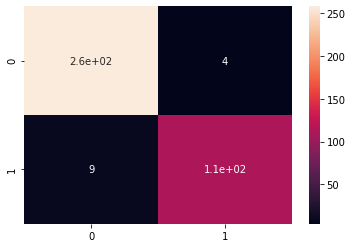

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_predict)
print('%.4f'%accuracy)

cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)

print(classification_report(y_test, y_predict))